In [3]:
import jax.experimental.ode as ode
import jax
import ticktack
import time

In [4]:
parameters = (774.86, 0.25, 0.8, 6.44)
model = ticktack.load_presaved_model("Guttler15", production_rate_units="atoms/cm^2/s")
model.compile()

STEADY_PROD = model.equilibrate(target_C_14=707.)
STEADY_STATE = model.equilibrate(production_rate=STEADY_PROD)
PROD_COEFFS = model._production_coefficients
MATRIX = model._matrix
GROWTH = model

del model

In [5]:
def profile(func, *args, **kwargs) -> tuple:
    time_sample = jax.numpy.zeros(10)  # Storing the trials
    
    for i in range(10):
        timer = time.process_time()             # Starting a timer 
        solution = func(*args, **kwargs)    # Running the model 
        timer = time.process_time() - timer     # Stopping the timer

        time_sample = time_sample.at[i].set(timer)  # Storing the timer 

    return {
        "average": float(jax.numpy.mean(time_sample.at[1:].get())), 
        "solution": solution
        }

In [6]:
@jax.tree_util.Partial
@jax.jit
def production(t, args):
    start_time, duration, phase, area = jax.numpy.array(args)
    middle = start_time + duration / 2.
    height = area / duration

    gauss = height * jax.numpy.exp(- ((t - middle) / (1. / 1.93516 * duration)) ** 16.)
    sine = 1.8803862513018528 + 0.18 * 1.8803862513018528 *\
        jax.numpy.sin(2 * jax.numpy.pi / 11 * t + phase * 2 * jax.numpy.pi / 11) 
        
    return (sine + gauss) * 3.747273140033743

In [7]:
@jax.tree_util.Partial
@jax.jit
def derivative(y, t, args, /, matrix=MATRIX, production=production, prod_coeffs=PROD_COEFFS): 
    
    ans = jax.numpy.matmul(matrix, y) 
    production_rate_constant = production(t, args)
    production_term = prod_coeffs * production_rate_constant 
    return ans + production_term 

In [8]:
@jax.tree_util.Partial
@jax.jit
def solve(y_initial, time, args, /, dydx=derivative):
    states = ode.odeint(dydx, y_initial, time, args)
    return states[:, 1]

In [9]:
with open("miyake12.csv") as data:
    _ = next(data)  # String titles 
    data = jax.numpy.array([row.strip().split(" ") for row in data],\
        dtype=jax.numpy.float64)
    data = data.T

In [10]:
@jax.tree_util.Partial
@jax.jit
def bin_data(data, time_out, growth, kernel):    
    # These top two return the index of the first one and the first zero
    first1 = jax.numpy.where(growth == 1, size=1)[0][0]
    first0 = jax.numpy.where(growth == 0, size=1)[0][0]

    # Here we zone onto the start of wrapped seasons
    all1s = jax.numpy.where(growth == 1, size=12)[0]
    after1 = jax.numpy.where(all1s > first0, all1s, 0)
    after1 = after1.at[jax.numpy.nonzero(after1, size=1)].get()[0]

    # difference between the wrapped and non-wrapped 
    num = jax.lax.sub(first1, after1)

    # if the season is not wrapped then return the index of the season start.
    # if the seasoon is wrapped return the start and the difference
    val = jax.lax.cond(num == 0, lambda: first1, lambda: after1)
    # Make sure that the tree doesn't grow all year around 
    shifted_index = jax.lax.cond(jax.numpy.all(growth == 1), lambda: 0, lambda: val)

    oversample = kernel.shape[0]

    @jax.jit
    def fun(i, val, /, oversample=oversample, data=data, kernel=kernel, shifted_index=shifted_index):
        # So val is the array that is getting updated here
        translated_index = i * oversample + shifted_index * oversample // 12
        year_from_index = jax.lax.dynamic_slice(data, (translated_index,), (oversample,))
        selected_data = jax.numpy.multiply(year_from_index, kernel)
        year_mean = jax.numpy.array([jax.numpy.sum(selected_data) / (jax.numpy.sum(kernel))])

        # So this will update val 
        solution = jax.lax.dynamic_update_slice(val, year_mean, (i,))
        return solution 

    binned_data = jax.numpy.zeros((len(time_out),))
    binned_data = jax.lax.fori_loop(0, len(time_out), fun, binned_data)

    return binned_data

In [11]:
oversample = 1008
growth = jax.numpy.array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0], dtype=jax.numpy.float64)
time_out = jax.numpy.linspace(data[0].min(), data[0].max() + 2, (data[0].size + 1) * oversample)

So what are the assumptions that we are making with thhe binning? 
 - We are assuming that the values start at the beggining of a year
 - We are assuming that the growth seasons are continuous
 - We are _not_ assuming that oversample fits as `array.reshape`.
 - We are _not_ assuming that the growth season has a particular length 
I want my binnig function to take an arbitrary growth season and extend it to be the kernel. So each value in the growth will be extended to `oversample // 12` long. In non `jax` psuedo-code this looks something like:
```py


In [12]:
def get_growth_kernel(oversample, /, growth=growth):
    masked = jax.numpy.linspace(0, 1, oversample)
    # So the kernel represents the fraction of decimals between 0 and 1 that are less than the length of the growth season normalised
    kernel = (masked < jax.numpy.count_nonzero(growth)/12)
    return kernel

In [13]:
@jax.tree_util.Partial
@jax.jit
def log_likelihood_binned(args, /, data=data, func=solve, bin=bin_data, y0=STEADY_STATE,\
    growth=growth, time_out=time_out, kernel=None):

    solution = func(y0, time_out, args)
    solution = bin(solution, data[0], growth, kernel)
    solution = (solution - STEADY_STATE[1]) / STEADY_STATE[1]
    solution += jax.numpy.mean(data[1][:4])
    chi_squared = (solution - data[1]) ** 2 / data[2] ** 2
    return - 0.5 * jax.numpy.sum(chi_squared)

In [15]:
jac_binned = jax.jit(jax.grad(log_likelihood_binned))
hes_binned = jax.jit(jax.jacobian(jac_binned))

In [120]:
results = {
    "oversample": range(1, 100),
    "log_likelihood_time": [],
    "log_likelihood_output": [],
    "grad_time": [],
    "grad_param_1": [],
    "grad_param_2": [],
    "grad_param_3": [],
    "grad_param_4": []
}

In [121]:
for index, oversample in enumerate(results["oversample"]):
    time_out = jax.numpy.linspace(data[0].min(), data[0].max() + 2, (data[0].size + 1) * oversample)
    kernel = get_growth_kernel(oversample)

    log_likelihood = profile(log_likelihood_binned, parameters, time_out=time_out, kernel=kernel)
    results["log_likelihood_time"].append(log_likelihood["average"])
    results["log_likelihood_output"].append(float(log_likelihood["solution"]))

    gradient = profile(jac_binned, parameters, time_out=time_out, kernel=kernel)
    results["grad_time"].append(gradient["average"])
    results["grad_param_1"].append(float(gradient["solution"][0]))
    results["grad_param_2"].append(float(gradient["solution"][1]))
    results["grad_param_3"].append(float(gradient["solution"][2]))
    results["grad_param_4"].append(float(gradient["solution"][3]))

In [122]:
from plotnine import *
import pandas
import numpy

In [123]:
results["grad_param_1"] = (results["grad_param_1"] - numpy.mean(results["grad_param_1"])) / numpy.mean(results["grad_param_1"])
results["grad_param_2"] = (results["grad_param_2"] - numpy.mean(results["grad_param_2"])) / numpy.mean(results["grad_param_2"])
results["grad_param_3"] = (results["grad_param_3"] - numpy.mean(results["grad_param_3"])) / numpy.mean(results["grad_param_3"])
results["grad_param_4"] = (results["grad_param_4"] - numpy.mean(results["grad_param_4"])) / numpy.mean(results["grad_param_4"])

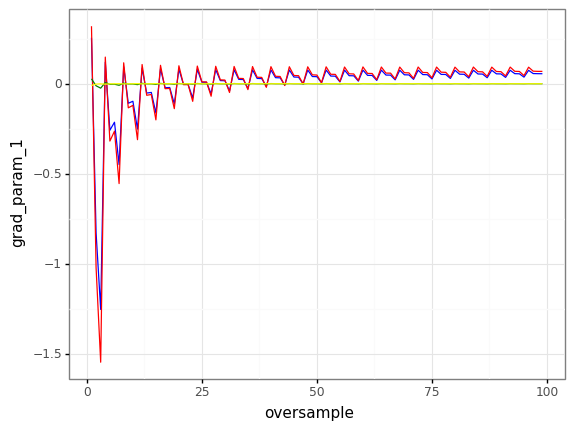

<ggplot: (8751618282081)>

In [128]:
results = pandas.DataFrame(results)
(ggplot(results, aes(x="oversample"))
    + geom_line(aes(y="grad_param_1"), color="blue")
    + geom_line(aes(y="grad_param_2"), color="red")
    + geom_line(aes(y="grad_param_3"), color="green")
    + geom_line(aes(y="grad_param_4"), color="yellow")
    + theme_bw())

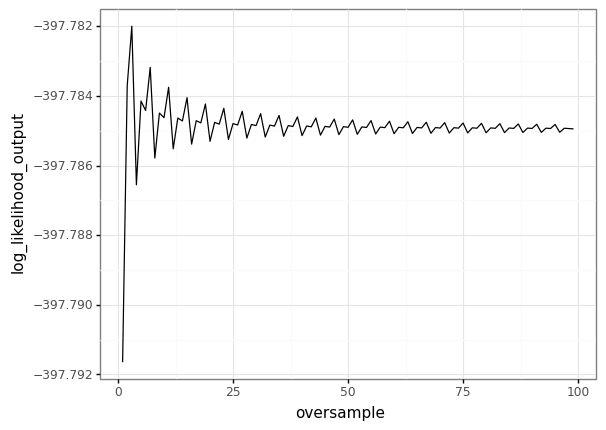

<ggplot: (8751618319535)>

In [127]:
(ggplot(results, aes(x="oversample", y="log_likelihood_output"))
    + geom_line()
    + theme_bw())